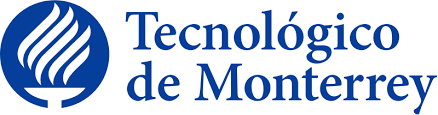

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey
###Asesor: Luis Eduardo Falcón Morales
## **Modelo Final Logistic Regression**
###**Equipo 18:**
###**A01793052 - Juan Carlos Lopez Cruz**


## **Libraries to install**

In [48]:
# Just run this if you have not download the Fasttext embbedbings Model.
!pip install datasets
!pip install fasttext # just run once and then return it as a comment

## **Libraries to be used**

In [49]:
## Library for Datasets manipulation
from datasets import Dataset, load_dataset, DatasetDict

## Libraries to manipulate and plot data.
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files

# Libraries for Data processing.
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Libraries for Machine learning.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score

# Libraries for Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Library for TFIDF for text encoding.
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Matrix

# Library for TFIDF for text encoding.
import fasttext
import fasttext.util



# **Load Data from Github**

In [50]:
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments.csv'
data= pd.read_csv(url)
data

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
1658,After reading about sudden accelerations in Je...,NaN
1659,My 2002 Jeep Grand Cherokee Limited takes off ...,NaN
1660,As I was braking at a stoplight my 2000 Jeep G...,NaN
1661,About 1 1/2 months ago my wife complained to m...,NaN


## **Recent Data to evaluate models with 2nd test data.**

This data was extracted from the https://www.edmunds.com/ website for Jeep Vehicles 2022,2023 and 2024. The reason to use data from different data set is to evaluate the robustness of the Model.

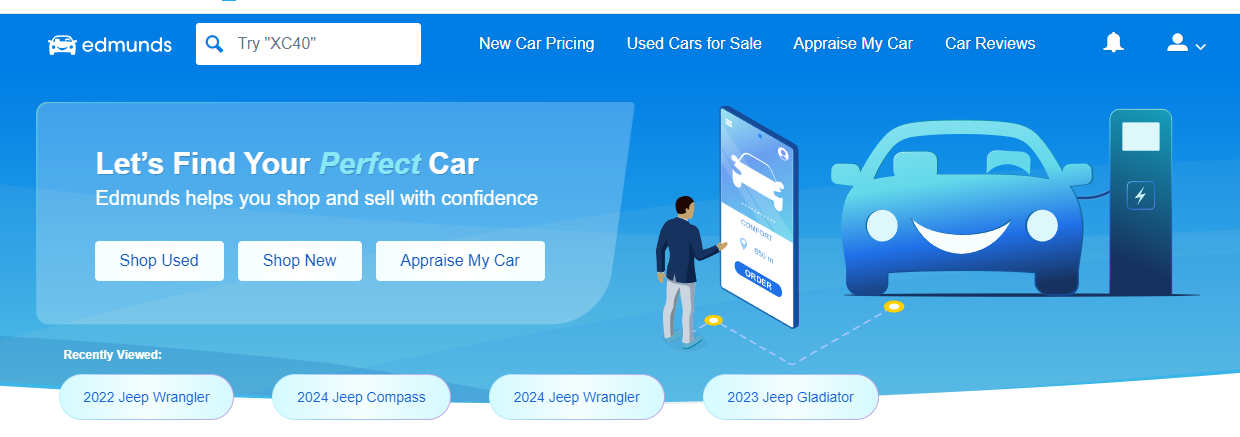

In [51]:
url2= 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments_fromedmunds.csv'
test_data=pd.read_csv(url2,encoding='latin1')
test_data

,text,stars,date,vehicle
0,"I special ordered my car , waited patiently fo...",1,6/25/2023,2024 Jeep Grand Cherokee L
1,Auto stop engine can not be permanently disabl...,2,12/30/2023,2023 Jeep Cherokee
2,I leased a high altitude in August 2034. I did...,1,12/30/2023,2024 Jeep Wrangler 4xe
3,Car is awesome! Couldnt be more happy with my...,5,12/30/2022,2024 Jeep Compass
4,Bought a brand new Rubicon for my son. Fully L...,1,12/30/2022,2024 Jeep Wrangler 4xe
...,...,...,...,...
303,Super happy with my purchase,5,06/01/2021,2023 Jeep Cherokee
304,Just the right size. the only complaint is the...,5,06/11/2020,2023 Jeep Renegade
305,This subcompact SUV is roomy enough for my fam...,5,09/10/2020,2023 Jeep Renegade
306,Gorgeous vehicle loaded with details comparabl...,5,12/09/2020,2023 Jeep Cherokee


# **EDA - Exploratory Data Analysis**

## **Elimination of nan rows.**

Since in the data extraction some reviews no rated, in these reviews the label was added **nan** , the first thing we must do is eliminate the data that does not have a label.

In [52]:
nan_data = data.isna()
print(nan_data)

      Review  Stars
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
1658   False   True
1659   False   True
1660   False   True
1661   False   True
1662   False   True

[1663 rows x 2 columns]


In [53]:
nan_test_data=test_data.isna()
print(nan_test_data)

      text  stars   date  vehicle
0    False  False  False    False
1    False  False  False    False
2    False  False  False    False
3    False  False  False    False
4    False  False  False    False
..     ...    ...    ...      ...
303  False  False  False    False
304  False  False  False    False
305  False  False  False    False
306  False  False  False    False
307  False  False  False    False

[308 rows x 4 columns]


In [54]:
data_clean= data.dropna(subset=['Stars']) # dropna will eliminate nan reviews. (reviews not rated)
data_clean=data_clean.reset_index(drop=True) #restar index
data_clean

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,1.0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,1.0
961,"I purchased a 2011 Grand Cherokee in July, 201...",2.0
962,I have a 2003 Jeep Grand Cherokee and have had...,1.0


## **Creation of binary label.**

Convert the rates scale (1,2,3,4,5) to binary problem (0,1)

**Justification:**

When it comes to converting scores from a multi-class classification problem to a binary problem, there are different approaches that can be taken. A common way to approach this situation is to set a threshold to divide ratings into positive and negative.

In this case, if you want to consider ratings between 3 and 4 as 3.5, it is possible to set a threshold at 3.5 to classify the ratings as positive or negative. Any rating equal to or greater than 3.5 would be considered positive, while any rating below 3.5 would be considered negative.

This choice is based on the assumption that a rating of 3.5 is somewhere between positive ratings (greater than 3.5) and negative ratings (less than 3.5). By considering the rating of 3.5 as positive, it is being assumed that comments with a rating close to 3.5 still contain positive elements and should therefore be treated as such.

However, it is important to note that the choice of threshold may depend on the specific context and requirements of the problem. In some cases, it may be more appropriate to adjust the threshold to classify ratings between 3 and 4 as positive or negative. This will depend on the distribution of ratings and how the concept of "positive" and "negative" is defined in the context of the problem at hand. In our case let's decide to consider ratings greater than or equal to 4 as positive and those less than 4 as negative.

In [55]:
ds = Dataset.from_dict({"text": data_clean.Review, "labels": [1 if star >= 4 else 0 for star in data_clean.Stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 964
})

In [56]:
ds.to_pandas()

,text,labels
0,Everything with them is 24 to 48 hours and eve...,0
1,So I went in to replace the hose radiator outl...,0
2,I was so excited to buy a Jeep but turns out i...,0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,0
4,I’m a mail carrier from the Dakotas.. so I pur...,0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,0
961,"I purchased a 2011 Grand Cherokee in July, 201...",0
962,I have a 2003 Jeep Grand Cherokee and have had...,0


### **Analysis of labels distribution of the Database**

In [57]:
# Calculate the ratio of positive and negative tags
label_count = ds.to_pandas().labels.value_counts()
proportion_negative, proportion_positive = (label_count/len(ds['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.13
% of negative comments: 0.87


In [58]:
label_count

0    841
1    123
Name: labels, dtype: int64

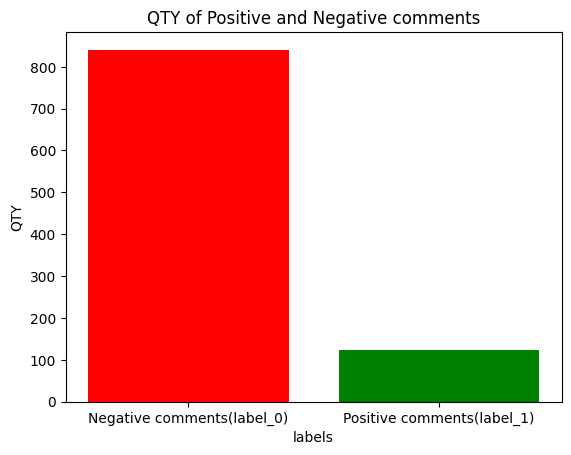

In [59]:
# Plot the proportions
labels = ['Negative comments(label_0)', 'Positive comments(label_1)']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, label_count.tolist(), color=['red', 'green'])
plt.xlabel('labels')
plt.ylabel('QTY')
plt.title('QTY of Positive and Negative comments')
plt.show()

In [60]:
ds_copy = ds.map()

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

## **2nd Test data creation of binary**

In [61]:
ds_test = Dataset.from_dict({"text": test_data.text, "labels": [1 if star >= 4 else 0 for star in test_data.stars]})
ds_test

Dataset({
    features: ['text', 'labels'],
    num_rows: 308
})

In [62]:
ds_test.to_pandas()

,text,labels
0,"I special ordered my car , waited patiently fo...",0
1,Auto stop engine can not be permanently disabl...,0
2,I leased a high altitude in August 2034. I did...,0
3,Car is awesome! Couldnt be more happy with my...,1
4,Bought a brand new Rubicon for my son. Fully L...,0
...,...,...
303,Super happy with my purchase,1
304,Just the right size. the only complaint is the...,1
305,This subcompact SUV is roomy enough for my fam...,1
306,Gorgeous vehicle loaded with details comparabl...,1


### **Analysis of labels distribution of the 2nd Test data**

In [63]:
# Calculate the ratio of positive and negative tags
label_count = ds_test.to_pandas().labels.value_counts()
proportion_positive, proportion_negative = (label_count/len(ds_test['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.71
% of negative comments: 0.29


In [64]:
label_count

1    220
0     88
Name: labels, dtype: int64

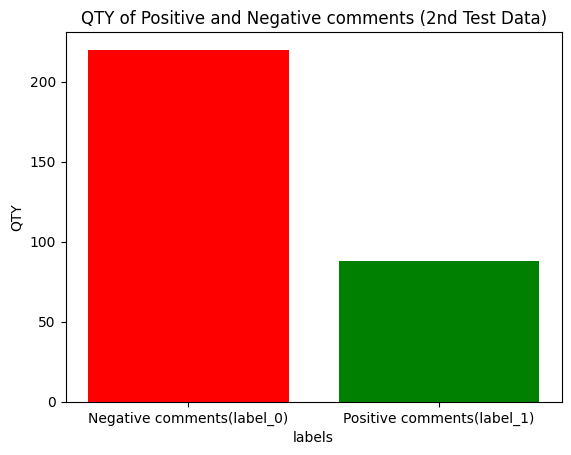

In [65]:
# Plot the proportions
labels = ['Negative comments(label_0)', 'Positive comments(label_1)']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, label_count.tolist(), color=['red', 'green'])
plt.xlabel('labels')
plt.ylabel('QTY')
plt.title('QTY of Positive and Negative comments (2nd Test Data)')
plt.show()

In [66]:
ds_copy = ds.map()

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

# **Load Augmented Data from Github**

In [67]:
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_synthetic_comments.csv'
url="https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_synthetic_comments%20V2.csv"
ds_synthetic= pd.read_csv(url)
ds_synthetic

,text,labels
0,"Jeep vehicle is a great car, but I can't get o...",1
1,"I love jeep car, but this is a brand new vehic...",1
2,My jeep car is the best I have ever had. I wil...,1
3,"I really enjoy jeep cars, but it is a very dan...",1
4,I will buy another jeep car again. I will neve...,1
...,...,...
415,I will never buy again a jeep car.\nI bought a...,0
416,Jeep vehicle is the worse car I have ever owne...,0
417,I do not like jeep car’s. I have owned many je...,0
418,My jeep car is bad. I have never had anything ...,0


In [68]:
# Calculate the ratio of positive and negative tags
label_count = ds_synthetic.labels.value_counts()
proportion_positive, proportion_negative = (label_count/len(ds_synthetic['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.95
% of negative comments: 0.05


In [69]:
label_count

1    400
0     20
Name: labels, dtype: int64

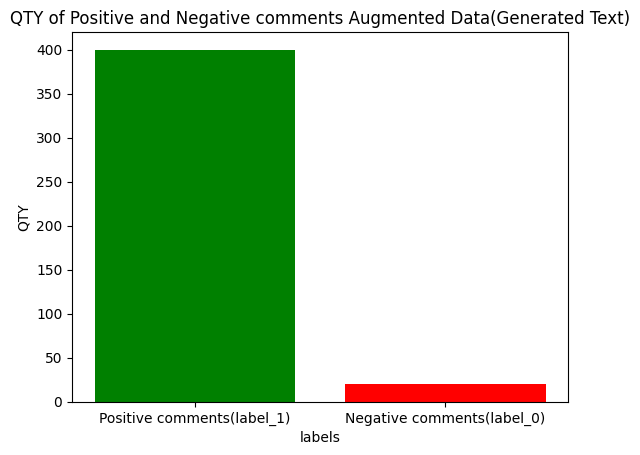

In [70]:
# Plot the proportions
labels = ['Positive comments(label_1)','Negative comments(label_0)']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, label_count.tolist(), color=['green', 'red'])
plt.xlabel('labels')
plt.ylabel('QTY')
plt.title('QTY of Positive and Negative comments Augmented Data(Generated Text)')
plt.show()

# <font color='Green'>**Using NLP Tools**

## **Load Data in to List.**


In [71]:
X=ds.to_pandas().text.tolist()
Y=ds.to_pandas().labels.tolist()
X_train_a=ds_synthetic.text.tolist() ## Augmented Data for Training
Y_train_a=ds_synthetic.labels.tolist() ## Augmented Data for Training
X_test2=ds_test.to_pandas().text.tolist() ## Data to test models from different web site
Y_test2=ds_test.to_pandas().labels.tolist() ## Data to test models from different web site


## **Text Preprocessing**

Stop words Elimination, Clean, Tokenization and lematization.

### Download the library of NLTK (Natural Language Toolkit) for data processing.

In [47]:
nltk.download('punkt')    # It is a tokenizer that helps split text into statements using an unsupervised model.
nltk.download('stopwords')    # to access stopwords in multiple languages.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Let's see the list of stopwords that are included by default in the NLTK library suite:

print(len(stopwords.words('english')))
print(stopwords.words('english'))

# Let's consider the following list of words associated with negations in English:

negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [ ]:
#Exclude all words in the "negwords" list from the default "stopwords" list, to define a new set called mystopwords

mystopwords = list(set(stopwords.words('english')) - set(negwords))

print(len(mystopwords))
print(mystopwords)


139
['they', 'her', 'can', 'been', 'our', 'there', 'under', 'some', 'were', 'that', 'yours', 'o', 'are', 'them', 'just', 'then', 'who', 'he', 'same', 'she', 'these', 'should', 'their', 'be', 'all', 'with', 'too', 'into', 'an', 'before', 'i', 'because', "you'd", 'was', 'until', 'by', 'as', 'after', 'your', 'a', 'other', 'itself', 'where', 'from', 'my', 'y', 'any', 'themselves', 'did', 'is', 'so', 'further', 'in', 'yourselves', 'its', 'while', 'this', 'hers', "should've", 'out', 'ours', 'or', 'why', 'him', 'you', 'few', 'm', 'here', 'on', 'again', 'and', 'does', 'against', 'above', 'whom', 't', 're', 'his', 'during', 'those', 'the', 'will', 'theirs', "it's", 'of', 'had', 'having', 'about', 've', 'below', 'it', 'off', 'me', 'each', 's', 'but', 'have', 'more', 'do', 'over', "you're", 'for', "you'll", 'herself', 'how', 'if', 'own', 'himself', "that'll", 'at', 'between', 'most', 'has', 'd', 'doing', 'which', 'very', 'through', 'll', 'to', 'we', 'up', 'down', 'what', 'ma', "you've", 'now', 's

## **Clean and tokenization:**

Justification of the cleaning process:

In the next block we define the function that will clean the text and return the tokens of each comment. The following steps were performed for the cleaning process:

1- Remove special characters: Punctuation marks and special characters do not add value to the type of analysis we want to perform. Therefore, not removing them could affect the performance of our model. For this reason it was decided to remove these characters.

2-Convert all letters to lowercase: This is done to prevent the model from identifying the same words as different but one written in lowercase and another in uppercase.

3-Stemming: This option was selected since when testing the model with both Stemming and Lemmatization, the latter tends to overtrain the model. In terms of accuracy, both have similar behavior for the data set we are working with.

**Note:** Rationale for the additional cleaning process:

Now we proceed to generate the clean comments. As a result of the cleaning, some lines remain empty so they are eliminated. Leaving these lines empty affects the performance of the model, since it considers them as part of the vocabulary during the analysis.

In [ ]:
# Clean and Tokenization:

def clean_tok(doc):
    ps=PorterStemmer()
    # With REGEX we replace with space everything that is not a letter or space, leaving only alphabetic characters
    doc = re.sub(r'[^A-Za-z\s]', ' ', doc)
    # With REGEX we replace all double or greater spaces with single spaces
    doc = re.sub(r'\s{2,}', ' ', doc)
    # We simplify everything to lowercase
    doc = doc.lower()
    # We apply tokenization
    doc = nltk.word_tokenize(doc)
    # We filter the stopwords, we consider only tokens greater than 1
    return [ps.stem(word) for word in doc if word not in mystopwords and len(word) > 1]

### **Clean and Tokenization for Original data**

In [ ]:
Xclean = np.array([clean_tok(x) for x in X], dtype=object)  #Comments processed
#Delete empty comments
filter_Xclean = [False if com == [] else True for com in Xclean]
Xclean = Xclean[filter_Xclean]

#Remove the Y's from these comments to maintain the size of the data set
Y = np.array(Y, dtype=object)
Y = Y[filter_Xclean]
for x in Xclean[5:10]:
  print(x)
Y[5:10] # labels

['name', 'deborah', 'purchas', 'compass', 'februari', 'mile', 'total', 'fell', 'love', 'vehicl', 'ran', 'like', 'dream', 'new', 'vehicl', 'mile', 'engin', 'start', 'run', 'rough', 'transmiss', 'start', 'shift', 'hard', 'took', 'dealership', 'per', 'recommend', 'jeep', 'custom', 'servic', 'open', 'case', 'said', 'check', 'certifi', 'chrysler', 'technician', 'check', 'softwar', 'updat', 'fix', 'shift', 'problem', 'gear', 'ask', 'owner', 'not', 'notifi', 'softwar', 'updat', 'told', 'way', 'find', 'softwar', 'updat', 'take', 'dealership', 'someth', 'els', 'return', 'jeep', 'transmiss', 'shift', 'becam', 'wors', 'return', 'dealership', 'day', 'technician', 'rode', 'felt', 'issu', 'discuss', 'week', 'jeep', 'dealership', 'multipl', 'technician', 'drove', 'felt', 'issu', 'transmiss', 'receiv', 'written', 'statement', 'pick', 'jeep', 'exact', 'issu', 'dealership', 'return', 'state', 'noth', 'wrong', 'show', 'no', 'code', 'jeep', 'custom', 'servic', 'close', 'case', 'within', 'week', 'transmiss

array([0, 0, 0, 0, 0], dtype=object)

### **Clean and Tokenization for Augmented data (Text generation) to be used only for training**

In [ ]:
Xclean_train_a = np.array([clean_tok(x) for x in X_train_a], dtype=object)  #Comments processed
#Delete empty comments
filter_Xclean_train_a = [False if com == [] else True for com in Xclean_train_a]
Xclean_train_a = Xclean_train_a[filter_Xclean_train_a]

#Remove the Y's from these comments to maintain the size of the data set
Y_train_a = np.array(Y_train_a, dtype=object)
Y_train_a = Y_train_a[filter_Xclean_train_a]

for x in Xclean_train_a[5:10]:
  print(x)
Y_train_a[5:10] # labels

['jeep', 'vehicl', 'great', 'car', 'love', 'jeep', 'grand', 'cheroke', 'also', 'love', 'fact', 'brand', 'new', 'vehicl', 'drive', 'anywher', 'excit', 'jeep', 'would', 'realli', 'like', 'see', 'brand', 'new', 'vehicl', 'like', 'jeep', 'liberti', 'shop', 'time', 'issu', 'jeep', 'loos', 'week', 'still', 'not', 'sure', 'littl', 'tight']
['love', 'jeep', 'car', 'first', 'time', 'deal', 'issu', 'disappoint', 'never', 'buy', 'anoth', 'jeep', 'grand', 'cheroke', 'limit', 'origin', 'manufactur', 'warranti', 'year', 'half', 'still', 'issu', 'first', 'problem', 'took', 'monday', 'morn', 'notic', 'air', 'bag', 'dash', 'start', 'leak', 'took', 'back', 'dealership', 'said']
['jeep', 'car', 'best', 'car', 'ever', 'own', 'driven', 'coupl', 'friend', 'famili', 'past', 'year', 'no', 'problem', 'happi', 'happi', 'jeep', 'bought', 'new', 'jeep', 'wrangler', 'latitud', 'march', 'first', 'experi', 'vehicl', 'cruis', 'ga', 'station', 'two', 'day', 'still', 'start', 'call', 'told', 'need', 'new']
['realli', '

array([1, 1, 1, 1, 1], dtype=object)

### **Clean and Tokenization for test data from different data base**

In [ ]:
x_test2= np.array([clean_tok(x) for x in X_test2], dtype=object)  #Comments processed
#Delete empty comments
filter_x_test2= [False if com == [] else True for com in X_test2]
x_test2 = x_test2[filter_x_test2]

#Remove the Y's from these comments to maintain the size of the data set
y_test2= np.array(Y_test2)
y_test2 = y_test2[filter_x_test2]

for x in x_test2[5:10]:
  print(x)
y_test2[5:10] # labels

['great', 'jeep']
['wow', 'gc', 'first', 'jeep', 'famili', 'ever', 'own', 'saw', 'pretti', 'impress', 'one', 'bought', 'gray', 'black', 'roof', 'exterior', 'van', 'quit', 'classi', 'look', 'somehow', 'manag', 'look', 'luxuri', 'even', 'side', 'realli', 'like', 'one', 'kind', 'strang', 'thing', 'didn', 'come', 'side', 'step', 'mud', 'guard', 'kind', 'strang', 'quadra', 'lift', 'air', 'suspens', 'lower', 'pretti', 'low', 'eas', 'enter', 'exit', 'big', 'rim', 'summit', 'reserv', 'trime', 'look', 'realli', 'nice', 'go', 'well', 'vehicl', 'problem', 'would', 'neg', 'affect', 'ride', 'qualiti', 'littl', 'bit', 'interior', 'also', 'not', 'would', 'expect', 'jeep', 'ton', 'featur', 'tech', 'everywher', 'massag', 'function', 'two', 'front', 'seat', 'work', 'realli', 'well', 'mcintosh', 'sound', 'system', 'perfectli', 'crisp', 'clear', 'deep', 'bass', 'ambient', 'light', 'realli', 'add', 'nice', 'touch', 'also', 'realli', 'like', 'big', 'mode', 'selector', 'nob', 'center', 'consol', 'feel', 'wel

array([1, 1, 1, 1, 0])

## **Word Cloud Analysis**

Word cloud analysis is a technique used to visualize the frequency of words within a given text corpus. It generates a visual representation where the size of each word corresponds to its frequency in the text.



In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos_tok=[]  # initialize lists of positive and negative tokens
neg_tok=[]

for x,c in zip(Xclean, Y):
  if c==1:
    pos_tok.extend(x)   # tokens used in positive comments
  else:
    neg_tok.extend(x)   # tokens used in negative comments

pt = ' '.join(pos_tok)  # we require a single string for each class for the word cloud.
nt = ' '.join(neg_tok)

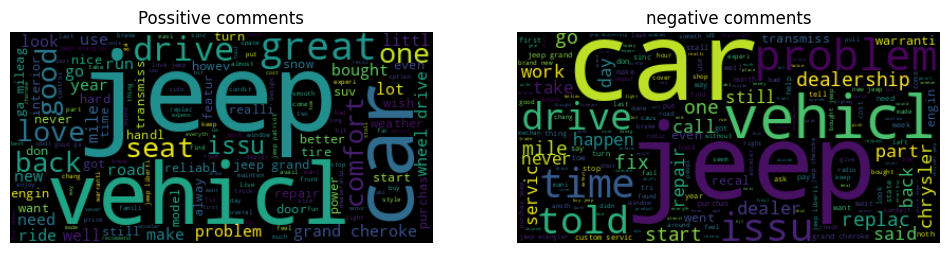

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

# Positive feedback word cloud:
wordcloudnn = WordCloud().generate(pt)
ax1.imshow(wordcloudnn, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Possitive comments')

# Negative comments word cloud:
wordcloudnn = WordCloud().generate(nt)
ax2.imshow(wordcloudnn, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('negative comments')

plt.show()

## **Data Split for Train, Validation and Test**

### **Original Data**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.80, shuffle=True, random_state=1,stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.5, shuffle=True, random_state=1, stratify=y_val_and_test)

print('X,y Train:', len(x_train), len(y_train))      # los "x_" son "list" y los "y_" son "Series"
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 771 771
X,y Val: 96 96
X,y Test 97 97


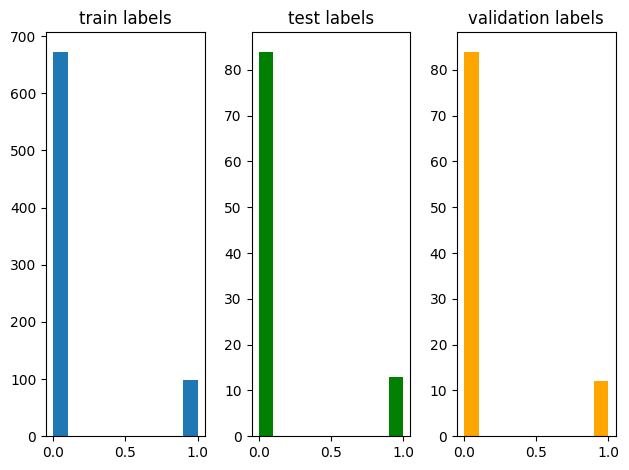

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(y_train)
ax2.set_title('test labels')
ax2.hist(y_test,color='green')
ax3.set_title('validation labels')
ax3.hist(y_val,color='orange')
fig.tight_layout()

### **Training data with Augmentation**

In [ ]:
x_train_a=np.concatenate((Xclean_train_a,x_train))
y_train_a=np.concatenate((Y_train_a,y_train))

Shuffle necesary to mix labels.

In [ ]:
x_train_a, _, y_train_a, _= train_test_split(x_train_a, y_train_a, train_size=0.99999, shuffle=True, random_state=1)

In [ ]:
print('X,y Train Augmented:', len(x_train_a), len(y_train_a))

X,y Train Augmented: 1190 1190


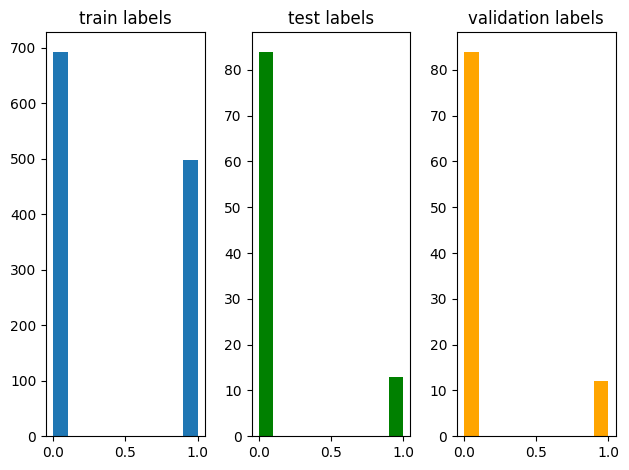

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(y_train_a)
ax2.set_title('test labels')
ax2.hist(y_test,color='green')
ax3.set_title('validation labels')
ax3.hist(y_val,color='orange')
fig.tight_layout()

### **2nd Test data**

Data is not necessary to shuffle because it would be for Test the model

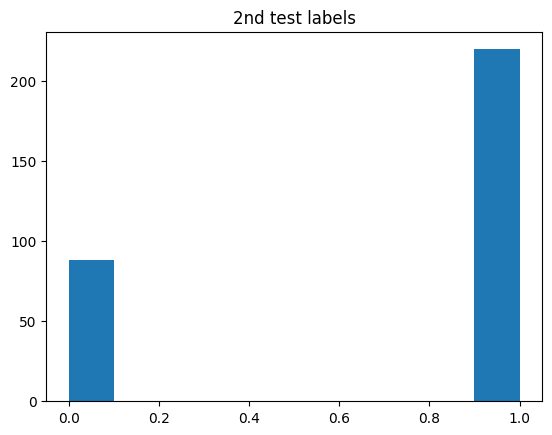

In [ ]:
from matplotlib import pyplot as plt
plt.hist(y_test2)
plt.title('2nd test labels')
plt.show()
fig.tight_layout()

## **Vocabulary creation and Filtration:**

In this step let's create a first vocabulary using only the training data. This data is used to avoid information leakage (data leak).

### **Vocabulary creation**

#### **Original Data**

In [ ]:
#We create a first vocabulary, which will not be cut so as not to lose information

from collections import Counter

vocab = Counter() #Vocabulario

for k in range(len(x_train)):
 vocab.update(x_train[k])

print('Training dictionary length:', len(vocab))
print('\n(word,frequency):')
print(vocab.most_common(100))


Training dictionary length: 4559

(word,frequency):
[('jeep', 2297), ('not', 1355), ('car', 1055), ('vehicl', 860), ('time', 647), ('problem', 645), ('would', 590), ('no', 564), ('dealership', 560), ('get', 556), ('back', 552), ('drive', 552), ('chrysler', 508), ('issu', 502), ('servic', 479), ('new', 426), ('mile', 421), ('call', 420), ('told', 414), ('go', 401), ('fix', 401), ('replac', 398), ('dealer', 390), ('one', 370), ('start', 366), ('year', 347), ('work', 342), ('day', 337), ('engin', 331), ('purchas', 325), ('warranti', 324), ('said', 322), ('cheroke', 314), ('light', 313), ('like', 305), ('month', 295), ('part', 291), ('never', 289), ('took', 281), ('bought', 280), ('transmiss', 273), ('could', 273), ('need', 267), ('still', 263), ('take', 252), ('custom', 247), ('repair', 244), ('week', 241), ('buy', 236), ('even', 235), ('happen', 226), ('anoth', 223), ('come', 219), ('went', 216), ('also', 214), ('recal', 205), ('don', 203), ('grand', 203), ('got', 199), ('want', 197), ('

**Note:** This additional step is to eliminate words with a frecuency 1 to avoid creating sparse matrices, since as the dictionary grows so will the matrices. The above would cause the model to be overtrained.

In [ ]:
#Considers a minimum frequency appropriate for the project

min_freq = 2

midicc = {k: v for k, v in vocab.items() if v >= min_freq}

print('New length of new vocabulary:', len(midicc))
print(list(midicc.items())[0:5]) # let's look at some dictionary items.

New length of new vocabulary: 2838
[('jeep', 2297), ('compass', 45), ('good', 130), ('ga', 128), ('glad', 10)]


#### **Training Data with Augmentation**

In [ ]:
#We create a first vocabulary, which will not be cut so as not to lose information

from collections import Counter

vocab_a = Counter() #Vocabulario

for k in range(len(x_train_a)):
 vocab_a.update(x_train_a[k])

print('Training dictionary length:', len(vocab_a))
print('\n(word,frequency):')
print(vocab_a.most_common(100))


Training dictionary length: 4571

(word,frequency):
[('jeep', 3456), ('car', 1778), ('not', 1680), ('vehicl', 1187), ('problem', 847), ('time', 818), ('dealership', 741), ('replac', 727), ('drive', 726), ('would', 723), ('no', 671), ('get', 669), ('issu', 655), ('back', 616), ('transmiss', 598), ('new', 587), ('cheroke', 569), ('chrysler', 551), ('like', 531), ('month', 528), ('dealer', 526), ('engin', 520), ('servic', 518), ('told', 517), ('year', 478), ('bought', 477), ('call', 468), ('one', 467), ('go', 461), ('fix', 458), ('mile', 449), ('start', 447), ('purchas', 446), ('said', 431), ('buy', 419), ('also', 418), ('work', 412), ('love', 396), ('day', 393), ('grand', 390), ('anoth', 390), ('never', 380), ('light', 372), ('took', 370), ('week', 369), ('still', 354), ('warranti', 354), ('take', 331), ('part', 318), ('could', 300), ('need', 296), ('first', 276), ('great', 262), ('custom', 260), ('repair', 259), ('come', 259), ('own', 258), ('lot', 256), ('recal', 256), ('even', 256), (

In [ ]:
#Considers a minimum frequency appropriate for the project

min_freq = 2

midicc_a = {k: v for k, v in vocab_a.items() if v >= min_freq}

print('New length of new vocabulary:', len(midicc_a))
print(list(midicc_a.items())[0:5]) # let's look at some dictionary items.

New length of new vocabulary: 2864
[('februari', 32), ('major', 51), ('accid', 56), ('cost', 143), ('lot', 256)]


### **Filtration**

Let's filter the Train, Validation and Test sets with respect to the new proposed vocabulary

In [ ]:
#Function to filter new vocabulary

def filter_out_empty_comments(doc: list, y: list) -> tuple:
    filter_list = [False if line == [] else True for line in doc]
    filtered_doc = np.array(doc, dtype=object)[filter_list]
    filtered_y = np.array(y, dtype = int)[filter_list]

    return (filtered_doc, filtered_y)

#### **Original Data**

In [ ]:
train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])

#Aditional test data
test2_x=[]
for ss in x_test2:
  test2_x.append([w for w in ss if w in midicc])


train_x, y_train = filter_out_empty_comments(train_x, y_train)
val_x, y_val = filter_out_empty_comments(val_x, y_val)
test_x, y_test = filter_out_empty_comments(test_x, y_test)
test2_x,y_test2 = filter_out_empty_comments(test2_x, y_test2)

#Review output
for k in range(3):
  print('before:', x_train[k])
  print('after:', train_x[k])

before: ['jeep', 'compass', 'good', 'ga', 'glad', 'pick', 'type', 'car', 'reason', 'price', 'suv', 'great', 'stereo', 'speaker', 'work', 'well', 'like', 'bluetooth', 'came', 'nice', 'hand', 'free', 'moreov', 'air', 'condit', 'work', 'great', 'compass', 'great', 'wish', 'leg', 'room', 'revers', 'camera', 'would', 'great', 'safeti', 'featur', 'also', 'like', 'front', 'window', 'side', 'front', 'window', 'bit', 'tint']
after: ['jeep', 'compass', 'good', 'ga', 'glad', 'pick', 'type', 'car', 'reason', 'price', 'suv', 'great', 'stereo', 'speaker', 'work', 'well', 'like', 'bluetooth', 'came', 'nice', 'hand', 'free', 'moreov', 'air', 'condit', 'work', 'great', 'compass', 'great', 'wish', 'leg', 'room', 'revers', 'camera', 'would', 'great', 'safeti', 'featur', 'also', 'like', 'front', 'window', 'side', 'front', 'window', 'bit', 'tint']
before: ['start', 'father', 'retir', 'chrysler', 'alway', 'chrysler', 'product', 'own', 'four', 'five', 'jeep', 'plu', 'chrysler', 'car', 'son', 'son', 'law', 'd

### **Augmented data**

In [ ]:
train_x_a = []
for ss in x_train_a:
  train_x_a.append([w for w in ss if w in midicc_a])

val_x_a = []
for ss in x_val:
  val_x_a.append([w for w in ss if w in midicc_a])

test_x_a = []
for ss in x_test:
  test_x_a.append([w for w in ss if w in midicc_a])

train_x_a, y_train_a = filter_out_empty_comments(train_x_a, y_train_a)
val_x_a, y_val_a = filter_out_empty_comments(val_x_a, y_val)
test_x_a, y_test_a = filter_out_empty_comments(test_x_a, y_test)

#Aditional test data
test2_x_a=[]
for ss in x_test2:
  test2_x_a.append([w for w in ss if w in midicc_a])
test2_x_a,y_test2_a=filter_out_empty_comments(test2_x_a, y_test2)



#Review output
for k in range(3):
  print('before:', x_train[k])
  print('after:', train_x[k])

before: ['jeep', 'compass', 'good', 'ga', 'glad', 'pick', 'type', 'car', 'reason', 'price', 'suv', 'great', 'stereo', 'speaker', 'work', 'well', 'like', 'bluetooth', 'came', 'nice', 'hand', 'free', 'moreov', 'air', 'condit', 'work', 'great', 'compass', 'great', 'wish', 'leg', 'room', 'revers', 'camera', 'would', 'great', 'safeti', 'featur', 'also', 'like', 'front', 'window', 'side', 'front', 'window', 'bit', 'tint']
after: ['jeep', 'compass', 'good', 'ga', 'glad', 'pick', 'type', 'car', 'reason', 'price', 'suv', 'great', 'stereo', 'speaker', 'work', 'well', 'like', 'bluetooth', 'came', 'nice', 'hand', 'free', 'moreov', 'air', 'condit', 'work', 'great', 'compass', 'great', 'wish', 'leg', 'room', 'revers', 'camera', 'would', 'great', 'safeti', 'featur', 'also', 'like', 'front', 'window', 'side', 'front', 'window', 'bit', 'tint']
before: ['start', 'father', 'retir', 'chrysler', 'alway', 'chrysler', 'product', 'own', 'four', 'five', 'jeep', 'plu', 'chrysler', 'car', 'son', 'son', 'law', 'd

## **Text Encoding or Text representation**

Text representation in NLP involves transforming raw text data into a format that machine learning models can understand and process effectively.

For this project we will compare 3 Techniques:

- Cont Vectorizer.
- TF-IDF (Term Frequency-Inverse Document Frequency).
- Word Embeddings -> Embedded FastText vectors pre-trained by Facebook.

## **1-Count vectorizer (Count Matrix)**
The count vectorizer is a way to represent text in natural language processing that converts a collection of documents into a document-word matrix. Encoding is therefore done at the document level, rather than at the token level.

Being a bag-of-words model, information regarding the position of the tokens or their context is not encoded, only information about whether they appear and their frequency.

### **Original Data**

In [ ]:
# Let's get the counting arrays
train_x_docs = []
for k in range(len(train_x)):
  train_x_docs.append(' '.join(train_x[k]))

val_x_docs = []
for k in range(len(val_x)):
  val_x_docs.append(' '.join(val_x[k]))

test_x_docs = []
for k in range(len(test_x)):
  test_x_docs.append(' '.join(test_x[k]))

## Aditional test data
test2_x_docs = []
for k in range(len(test2_x)):
  test2_x_docs.append(' '.join(test2_x[k]))


# let's verify that the first Train comments are each as a single string:
for k in range(3):
  print(train_x_docs[k])


jeep compass good ga glad pick type car reason price suv great stereo speaker work well like bluetooth came nice hand free moreov air condit work great compass great wish leg room revers camera would great safeti featur also like front window side front window bit tint
start father retir chrysler alway chrysler product own four five jeep plu chrysler car son son law dodg ram pickup truck chrysler blood never buy chrysler year ago like year chrysler known not start weather go back bought new jeep liberti not long bought replac whole transmiss experienc terribl ga mileag no mpg citi highway aw would gotten rid except four tow tow bar instal also brake buddi late key lock not work right slow thought need new batteri one morn went leav car dash light came wiper wouldn turn car lock park tri figur day dash final said no bu find mean anywher final got park drove dealership guess dash board cluster bad tune jeep mile warranti also year old chev truck mile never problem jeep plu get way better

In [ ]:
#let make the dicc to a list
mivocab = list(midicc.keys())

In [ ]:
# let's generate the required sparse matrices based on the token count:
from sklearn.feature_extraction.text import CountVectorizer

countvectorizer = CountVectorizer(vocabulary=mivocab)
train_x_count = countvectorizer.fit_transform(train_x_docs)
val_x_count = countvectorizer.transform(val_x_docs)
test_x_count = countvectorizer.transform(test_x_docs)

## Aditional data
test2_x_count = countvectorizer.transform(test2_x_docs)

count_tokens = countvectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data = train_x_count.toarray(),  columns = count_tokens)
print(df_countvect.iloc[0:3,6:18])

   type  car  reason  price  suv  great  stereo  speaker  work  well  like  \
0     1    1       1      1    1      4       1        1     2     1     2   
1     0    3       0      0    0      0       0        0     3     0     1   
2     0    0       0      0    0      0       0        0     0     0     0   

   bluetooth  
0          1  
1          0  
2          0  


In [ ]:
p_sparse = 1 - train_x_count.count_nonzero() / (train_x_count.shape[0] * train_x_count.shape[1])    # Sparsity : % of values in 0.
print('Percent of zero values of the training sparse matrix: %.1f%%' % (100*p_sparse))

Percent of zero values of the training sparse matrix: 97.7%


### **Augmented Data**



In [ ]:
# Let's get the counting arrays
train_x_docs_a = []
for k in range(len(train_x_a)):
  train_x_docs_a.append(' '.join(train_x_a[k]))

val_x_docs_a = []
for k in range(len(val_x_a)):
  val_x_docs_a.append(' '.join(val_x_a[k]))

test_x_docs_a = []
for k in range(len(test_x_a)):
  test_x_docs_a.append(' '.join(test_x_a[k]))

## Aditional test data
test2_x_docs_a = []
for k in range(len(test2_x_a)):
  test2_x_docs_a.append(' '.join(test2_x_a[k]))


# let's verify that the first Train comments are each as a single string:
for k in range(3):
  print(train_x_docs_a[k])

februari major accid cost lot vehicl hit driver door dump truck mph thank jeep frame took forc blow slid yard came stop besid electr pole jeep total lucki enough walk away scratch bruis think sold friend famili safe jeep son ask one th think wonder idea want say thank van wouldn made
deliveri jeep grand cheroke overland septemb notic exhaust smell cabin drive highway initi thought exhaust smell vehicl roadway exhaust fume continu time time drive car fall winter month abl reproduc problem drive highway sunroof tilt open driver side window slightli open ga pedal exhaust fume would sever enough fume would stop exit vehicl open window drive made exhaust fume cabin wors car servic relat issu least three time case open chrysler told vehicl oper design recent record carbon monoxid drive car commerci carbon monoxid devic
jeep liberti week drove lot notic heater not work took heater core blown sinc jeep blown time dealership locat florida manufactur not help repair thing malfunct time could not

In [ ]:
#let's make the dicc to a list
mivocab_a = list(midicc_a.keys())

In [ ]:
# let's generate the required sparse matrices based on the token count:
from sklearn.feature_extraction.text import CountVectorizer

countvectorizer = CountVectorizer(vocabulary=mivocab_a)
train_x_count_a = countvectorizer.fit_transform(train_x_docs_a)
val_x_count_a = countvectorizer.transform(val_x_docs_a)
test_x_count_a = countvectorizer.transform(test_x_docs_a)

## Aditional data
test2_x_count_a = countvectorizer.transform(test2_x_docs_a)

count_tokens = countvectorizer.get_feature_names_out()
df_countvect_a = pd.DataFrame(data = train_x_count_a.toarray(),  columns = count_tokens)
print(df_countvect_a.iloc[0:3,6:18])

   hit  driver  door  dump  truck  mph  thank  jeep  frame  took  forc  blow
0    1       1     1     1      1    1      2     3      1     1     1     1
1    0       1     0     0      0    0      0     1      0     0     0     0
2    0       0     0     0      0    0      0     3      0     1     0     0


## **2-TF-IDF Score Vectorizer**

In populating the Document-Term Matrix with the number of occurrences, frequently occurring terms are assigned a higher score than the rarely occurring terms.

TF-IDF score is a combination of two metrics: the Term Frequency (TF) and the Inverse Document Frequency (IDF).

### **Original Data**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(vocabulary=mivocab)

#Training the model in train
train_x_tfidf = tfid.fit_transform(train_x_docs)
val_x_tfidf = tfid.transform(val_x_docs)

#Training results
tfidf_tokens = tfid.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = train_x_tfidf.toarray(),  columns = tfidf_tokens)
print(df_tfidfvect.iloc[0:3,6:18])

#Transformation of test data
test_x_tfidf = tfid.transform(test_x_docs)

#Transformation of additional test data
test2_x_tfidf = tfid.transform(test2_x_docs)



       type       car    reason     price       suv     great    stereo  \
0  0.145736  0.057267  0.125061  0.131817  0.126621  0.426087  0.170947   
1  0.000000  0.094283  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

    speaker      work      well      like  bluetooth  
0  0.182351  0.149369  0.093134  0.149055   0.193109  
1  0.000000  0.122959  0.000000  0.040900   0.000000  
2  0.000000  0.000000  0.000000  0.000000   0.000000  


### **Augmented Training Data**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_a = TfidfVectorizer(vocabulary=mivocab_a)

#Training the model in train
train_x_tfidf_a = tfid_a.fit_transform(train_x_docs_a)
val_x_tfidf_a = tfid_a.transform(val_x_docs_a)

#Training results
tfidf_tokens_a = tfid_a.get_feature_names_out()
df_tfidfvect_a = pd.DataFrame(data = train_x_tfidf_a.toarray(),  columns = tfidf_tokens_a)
print(df_tfidfvect_a.iloc[0:3,6:18])

#Transformation of test data
test_x_tfidf_a = tfid_a.transform(test_x_docs_a)

#Transformation of additional test data
test2_x_tfidf_a = tfid_a.transform(test2_x_docs_a)


        hit    driver      door    dump    truck       mph     thank  \
0  0.120883  0.114526  0.106012  0.1962  0.12191  0.120883  0.249285   
1  0.000000  0.064712  0.000000  0.0000  0.00000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.0000  0.00000  0.000000  0.000000   

       jeep     frame      took      forc      blow  
0  0.096195  0.154181  0.080419  0.151293  0.149945  
1  0.018118  0.000000  0.000000  0.000000  0.000000  
2  0.114946  0.000000  0.096094  0.000000  0.000000  


## **3-Embedded FastText vectors pre-trained by Facebook.**
FastText is a Gensim model used to perform word embedding and classification. In it, supervised and unsupervised learning algorithms are created that are used to obtain vector representations of words.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ft = fasttext.load_model('/content/drive/MyDrive/14-proyecto/cc.en.300.bin')

### **Original data**.

In [ ]:
fast_text_voca = {}

for w in range(len(mivocab)):
  fast_text_voca[mivocab[w]] = ft.get_word_vector(mivocab[w]) # Variable where the vocabulary generated by FastText is stored.
## Save dictionary to an npy file.
np.save('fast_text_voca.npy', fast_text_voca)

In [ ]:
# Remove comments if you want to load the dictionary created with the 300 embedded vectors.

import numpy as np
##Reading the npy file.
#fast_text_voca = np.load('fast_text_voca.npy', allow_pickle='TRUE')
#fast_text_voca=fast_text_voca.item()  # Se convierte la variable de numpy array a diccionario.
print("Number of tokens:",len(fast_text_voca))
print("Number of pre-trained embedded vectors of the word 'much':",len(fast_text_voca.get('much')))

Number of tokens: 2838
Number of pre-trained embedded vectors of the word 'much': 300


In [ ]:
trainEmb = []
for ss in train_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  trainEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
trainEmb=np.array(trainEmb)# convert to matrix

valEmb = []
for ss in val_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  valEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
valEmb=np.array(valEmb)# convert to matrix

testEmb = []
for ss in test_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  testEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
testEmb=np.array(testEmb)# convert to matrix

## Aditional Test data
test2Emb = []
for ss in test2_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  test2Emb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
test2Emb=np.array(test2Emb)# convert to matrix


print("Training set dimensions:",trainEmb.shape)
print("Validation set dimensions:",valEmb.shape)
print("Test set dimensions",testEmb.shape)
print("2nd Test set dimensions",test2Emb.shape)


Training set dimensions: (771, 300)
Validation set dimensions: (96, 300)
Test set dimensions (97, 300)
2nd Test set dimensions (308, 300)


### **Augmented Data**

In [ ]:
fast_text_voca_a = {}

for w in range(len(mivocab_a)):
  fast_text_voca_a[mivocab_a[w]] = ft.get_word_vector(mivocab_a[w]) # Variable where the vocabulary generated by FastText is stored.
## Save dictionary to an npy file.
np.save('fast_text_voca_a.npy', fast_text_voca_a)

In [ ]:
# Remove comments if you want to load the dictionary created with the 300 embedded vectors.

import numpy as np
##Reading the npy file.
#fast_text_voca = np.load('fast_text_voca.npy', allow_pickle='TRUE')
#fast_text_voca=fast_text_voca.item()  # Se convierte la variable de numpy array a diccionario.
print("Number of tokens:",len(fast_text_voca_a))
print("Number of pre-trained embedded vectors of the word 'much':",len(fast_text_voca.get('much')))

Number of tokens: 2864
Number of pre-trained embedded vectors of the word 'much': 300


In [ ]:
trainEmb_a = []
for ss in train_x_a:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca_a[w])
  trainEmb_a.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
trainEmb_a=np.array(trainEmb_a)# convert to matrix

valEmb_a = []
for ss in val_x_a:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca_a[w])
  valEmb_a.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
valEmb_a=np.array(valEmb_a)# convert to matrix

testEmb_a = []
for ss in test_x_a:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca_a[w])
  testEmb_a.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
testEmb_a=np.array(testEmb_a)# convert to matrix

## Aditional Test data
test2Emb_a = []
for ss in test2_x_a:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca_a[w])
  test2Emb_a.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
test2Emb_a=np.array(test2Emb_a)# convert to matrix


print("Training set dimensions:",trainEmb_a.shape)
print("Validation set dimensions:",valEmb_a.shape)
print("Test set dimensions",testEmb_a.shape)
print("2nd Test set dimensions",test2Emb_a.shape)


Training set dimensions: (1190, 300)
Validation set dimensions: (96, 300)
Test set dimensions (97, 300)
2nd Test set dimensions (308, 300)


# **Machine Learning Models Logistic Regression**

Logistic Regression  will be used to evaluate the 3 text encoding conditions:

### **Logistic Regression**

#### **Function GridsearchCV to find best parameters**

In [ ]:


def logistic_regression_grid_search(X_train, y_train):

    # Define the parameter grid for Grid Search
    param_grid = {
        'penalty': ['l2', 'elasticnet', None],
        'C': [0.005, 0.05, 0.5, 1.0],
        'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 300],
        'class_weight': [None, 'balanced'],
        'n_jobs':[-1]
    }

    # Initialize the Logistic Regression model
    lr_model = LogisticRegression()

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(lr_model, param_grid, cv=5, verbose=2)
    grid_search.fit(X_train, y_train)
    #print(grid_search.best_params_)
    # Return the best parameters found by Grid Search
    return grid_search.best_params_



#### **Count Matrix -> Count Vectorizer**

##### **Count Vectorizer with Original Data**

In [ ]:
best_params_count = logistic_regression_grid_search(train_x_count,y_train)

In [ ]:
print(best_params_count)

{'C': 0.005, 'class_weight': 'balanced', 'max_iter': 200, 'n_jobs': -1, 'penalty': None, 'solver': 'sag'}


In [ ]:
LR_model_count=LogisticRegression(**best_params_count)

In [ ]:
LR_model_count.fit(train_x_count,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.005, class_weight='balanced', max_iter=200, n_jobs=-1,
                   penalty=None, solver='sag')

In [ ]:
print('Results using "Count Vectorizer"')
print('Results Logistic Regression:')
print('LR_count: Train-accuracy: %.2f%%' % (100*LR_model_count.score(train_x_count, y_train)))
print('LR_count: Val-accuracy: %2.f%%' % (100*LR_model_count.score(val_x_count, y_val)))
LR_count_train=100*LR_model_count.score(train_x_count, y_train)
LR_count_val=100*LR_model_count.score(val_x_count, y_val)

Results using "Count Vectorizer"
Results Logistic Regression:
LR_count: Train-accuracy: 98.83%
LR_count: Val-accuracy: 94%


##### **Model Evaluation**

######**Test data from same Data base**

Confusion matrix for Logistic Regression (RL) Count Vectorizer with original test data
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        84
           1       0.73      0.62      0.67        13

    accuracy                           0.92        97
   macro avg       0.83      0.79      0.81        97
weighted avg       0.91      0.92      0.91        97



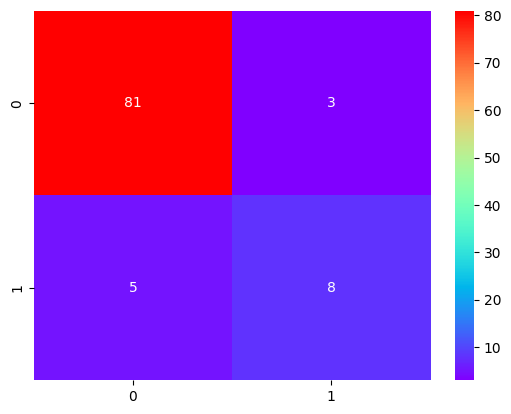

In [ ]:
y_pred_LR_count = LR_model_count.predict(test_x_count)
cm_LR_count = confusion_matrix(np.array(y_test),y_pred_LR_count)
sns.heatmap(cm_LR_count, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) Count Vectorizer with original test data")
print(classification_report(y_test,y_pred_LR_count))

In [ ]:
LR_count=classification_report(y_test,y_pred_LR_count,output_dict=True)
LR_count=pd.DataFrame(LR_count)
LR_count= LR_count.transpose()
LR_count

,precision,recall,f1-score,support
0,0.941860,0.964286,0.952941,84.000000
1,0.727273,0.615385,0.666667,13.000000
accuracy,0.917526,0.917526,0.917526,0.917526
macro avg,0.834567,0.789835,0.809804,97.000000
weighted avg,0.913101,0.917526,0.914574,97.000000


###### **Test data from same 2nd Data base**

Confusion matrix for Logistic Regression (RL) Count Vectorizer with 2nd test data
              precision    recall  f1-score   support

           0       0.65      0.94      0.77        88
           1       0.97      0.80      0.88       220

    accuracy                           0.84       308
   macro avg       0.81      0.87      0.82       308
weighted avg       0.88      0.84      0.85       308



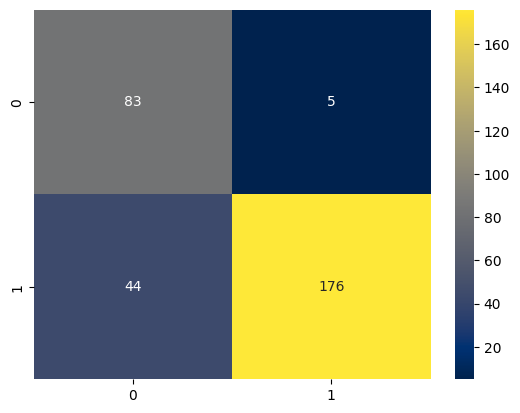

In [ ]:
y_pred_LR_count2 = LR_model_count.predict(test2_x_count)
cm_LR_count2 = confusion_matrix(np.array(y_test2),y_pred_LR_count2)
sns.heatmap(cm_LR_count2, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) Count Vectorizer with 2nd test data")
print(classification_report(y_test2,y_pred_LR_count2))

In [ ]:
LR_count2=classification_report(y_test2,y_pred_LR_count2,output_dict=True)
LR_count2=pd.DataFrame(LR_count2)
LR_count2= LR_count2.transpose()
LR_count2

,precision,recall,f1-score,support
0,0.653543,0.943182,0.772093,88.000000
1,0.972376,0.800000,0.877805,220.000000
accuracy,0.840909,0.840909,0.840909,0.840909
macro avg,0.812959,0.871591,0.824949,308.000000
weighted avg,0.881281,0.840909,0.847602,308.000000


##### **Count Vectorizer with Augmented Data**

In [ ]:
best_params_count_a = logistic_regression_grid_search(train_x_count_a,y_train_a)

In [ ]:
print(best_params_count_a)

{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'sag'}


In [ ]:
LR_model_count_a=LogisticRegression(**best_params_count_a)

In [ ]:
LR_model_count_a.fit(train_x_count_a,y_train_a)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1,
                   solver='sag')

In [ ]:
print('Results using "Count Vectorizer with Augmented Data"')
print('Results Logistic Regression:')
print('LR_count: Train-accuracy: %.2f%%' % (100*LR_model_count_a.score(train_x_count_a, y_train_a)))
print('LR_count: Val-accuracy: %2.f%%' % (100*LR_model_count_a.score(val_x_count_a, y_val_a)))
LR_count_train_a=100*LR_model_count_a.score(train_x_count_a, y_train_a)
LR_count_val_a=100*LR_model_count_a.score(val_x_count_a, y_val_a)

Results using "Count Vectorizer with Augmented Data"
Results Logistic Regression:
LR_count: Train-accuracy: 97.98%
LR_count: Val-accuracy: 93%


##### **Model Evaluation - Augmented**

######**Test data from same Data base**

Confusion matrix for Logistic Regression (RL) Count Vectorizer Augmented with original test data
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        84
           1       0.75      0.46      0.57        13

    accuracy                           0.91        97
   macro avg       0.84      0.72      0.76        97
weighted avg       0.90      0.91      0.90        97



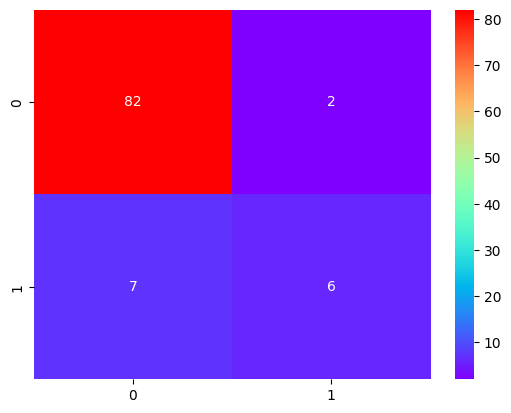

In [ ]:
y_pred_LR_count_a = LR_model_count_a.predict(test_x_count_a)
cm_LR_count_a = confusion_matrix(np.array(y_test_a),y_pred_LR_count_a)
sns.heatmap(cm_LR_count_a, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) Count Vectorizer Augmented with original test data")
print(classification_report(y_test_a,y_pred_LR_count_a))

In [ ]:
LR_count_a=classification_report(y_test_a,y_pred_LR_count_a,output_dict=True)
LR_count_a=pd.DataFrame(LR_count_a)
LR_count_a= LR_count_a.transpose()
LR_count_a

,precision,recall,f1-score,support
0,0.921348,0.976190,0.947977,84.000000
1,0.750000,0.461538,0.571429,13.000000
accuracy,0.907216,0.907216,0.907216,0.907216
macro avg,0.835674,0.718864,0.759703,97.000000
weighted avg,0.898384,0.907216,0.897512,97.000000


###### **Test data from same 2nd Data base**

Confusion matrix for Logistic Regression (RL) Count Vectorizer Augmented with 2nd test data
              precision    recall  f1-score   support

           0       0.54      0.92      0.68        88
           1       0.96      0.69      0.80       220

    accuracy                           0.75       308
   macro avg       0.75      0.80      0.74       308
weighted avg       0.84      0.75      0.77       308



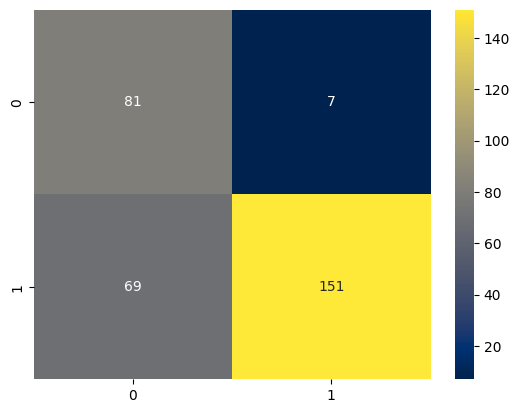

In [ ]:
y_pred_LR_count2_a = LR_model_count_a.predict(test2_x_count_a)
cm_LR_count2_a = confusion_matrix(np.array(y_test2_a),y_pred_LR_count2_a)
sns.heatmap(cm_LR_count2_a, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) Count Vectorizer Augmented with 2nd test data")
print(classification_report(y_test2_a,y_pred_LR_count2_a))

In [ ]:
LR_count2_a=classification_report(y_test2,y_pred_LR_count2_a,output_dict=True)
LR_count2_a=pd.DataFrame(LR_count2_a)
LR_count2_a= LR_count2_a.transpose()
LR_count2_a

,precision,recall,f1-score,support
0,0.540000,0.920455,0.680672,88.000000
1,0.955696,0.686364,0.798942,220.000000
accuracy,0.753247,0.753247,0.753247,0.753247
macro avg,0.747848,0.803409,0.739807,308.000000
weighted avg,0.836926,0.753247,0.765151,308.000000


#### **TF-IDF Score Vectorizer**

##### **TF-IDF Score Vectorizer with Original Data**

In [ ]:
best_params_tfidf = logistic_regression_grid_search(train_x_tfidf,y_train)

In [ ]:
print(best_params_tfidf)

{'C': 0.005, 'class_weight': 'balanced', 'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'sag'}


In [ ]:
LR_model_tfidf=LogisticRegression(**best_params_tfidf)

In [ ]:
LR_model_tfidf.fit(train_x_tfidf,y_train)

LogisticRegression(C=0.005, class_weight='balanced', n_jobs=-1, solver='sag')

In [ ]:
print('\nResults using "TF-IDF Score Vectorizer"')
print('Results Logistic Regression:')
print('LR_tfidf: Train-accuracy: %.2f%%' % (100*LR_model_tfidf.score(train_x_tfidf, y_train)))
print('LR_tfidf: Val-accuracy: %2.f%%' % (100*LR_model_tfidf.score(val_x_tfidf, y_val)))
LR_tfidf_train=100*LR_model_tfidf.score(train_x_tfidf, y_train)
LR_tfidf_val=100*LR_model_tfidf.score(val_x_tfidf, y_val)


Results using "TF-IDF Score Vectorizer"
Results Logistic Regression:
LR_tfidf: Train-accuracy: 96.89%
LR_tfidf: Val-accuracy: 95%


##### **Model Evaluation**

######**Test data from same Data base**

Confusion matrix for Logistic Regression (RL) Tfidf Vectorizer with original test data
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        84
           1       0.73      0.62      0.67        13

    accuracy                           0.92        97
   macro avg       0.83      0.79      0.81        97
weighted avg       0.91      0.92      0.91        97



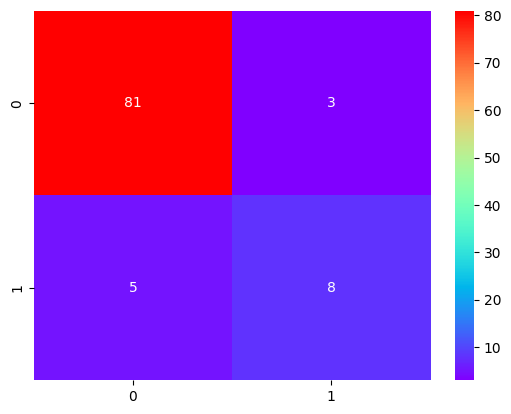

In [ ]:
y_pred_LR_tfidf = LR_model_tfidf.predict(test_x_tfidf)
cm_LR_tfidf = confusion_matrix(np.array(y_test),y_pred_LR_tfidf)
sns.heatmap(cm_LR_tfidf, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) Tfidf Vectorizer with original test data")
print(classification_report(y_test,y_pred_LR_tfidf))


In [ ]:
LR_tfidf=classification_report(y_test,y_pred_LR_tfidf,output_dict=True)
LR_tfidf=pd.DataFrame(LR_tfidf)
LR_tfidf= LR_tfidf.transpose()
LR_tfidf

,precision,recall,f1-score,support
0,0.941860,0.964286,0.952941,84.000000
1,0.727273,0.615385,0.666667,13.000000
accuracy,0.917526,0.917526,0.917526,0.917526
macro avg,0.834567,0.789835,0.809804,97.000000
weighted avg,0.913101,0.917526,0.914574,97.000000


###### **Test data from same 2nd Data base**

Confusion matrix for Logistic Regression (RL) Tfidf Vectorizer with 2nd test data
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        88
           1       0.93      0.85      0.88       220

    accuracy                           0.84       308
   macro avg       0.80      0.84      0.82       308
weighted avg       0.86      0.84      0.85       308



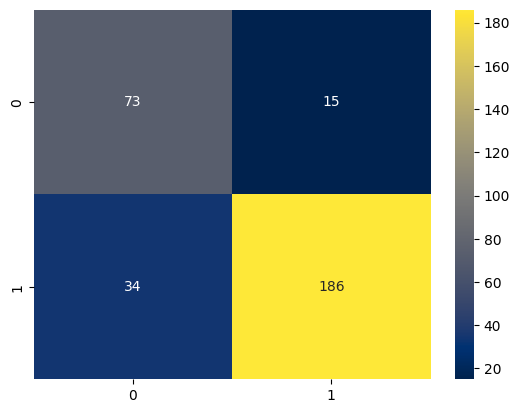

In [ ]:
y_pred_LR_tfidf2 = LR_model_tfidf.predict(test2_x_tfidf)
cm_LR_tfidf2 = confusion_matrix(np.array(y_test2),y_pred_LR_tfidf2)
sns.heatmap(cm_LR_tfidf2, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) Tfidf Vectorizer with 2nd test data")
print(classification_report(y_test2,y_pred_LR_tfidf2))

In [ ]:
LR_tfidf2=classification_report(y_test2,y_pred_LR_tfidf2,output_dict=True)
LR_tfidf2=pd.DataFrame(LR_tfidf2)
LR_tfidf2= LR_tfidf2.transpose()
LR_tfidf2

,precision,recall,f1-score,support
0,0.682243,0.829545,0.748718,88.000000
1,0.925373,0.845455,0.883610,220.000000
accuracy,0.840909,0.840909,0.840909,0.840909
macro avg,0.803808,0.837500,0.816164,308.000000
weighted avg,0.855907,0.840909,0.845070,308.000000


##### **TF-IDF Score Vectorizer with Augmented Data**

In [ ]:
best_params_tfidf_a = logistic_regression_grid_search(train_x_tfidf_a,y_train_a)

In [ ]:
print(best_params_tfidf_a)

{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
LR_model_tfidf_a=LogisticRegression(**best_params_tfidf_a)

In [ ]:
LR_model_tfidf_a.fit(train_x_tfidf_a,y_train_a)

LogisticRegression(class_weight='balanced', n_jobs=-1, solver='saga')

In [ ]:
print('\nResults using "TF-IDF Score Vectorizer with Augmented data"')
print('Results Logistic Regression:')
print('LR_tfidf: Train-accuracy: %.2f%%' % (100*LR_model_tfidf_a.score(train_x_tfidf_a, y_train_a)))
print('LR_tfidf: Val-accuracy: %2.f%%' % (100*LR_model_tfidf_a.score(val_x_tfidf_a, y_val_a)))
LR_tfidf_train_a=100*LR_model_tfidf_a.score(train_x_tfidf_a, y_train_a)
LR_tfidf_val_a=100*LR_model_tfidf_a.score(val_x_tfidf_a, y_val_a)


Results using "TF-IDF Score Vectorizer with Augmented data"
Results Logistic Regression:
LR_tfidf: Train-accuracy: 96.13%
LR_tfidf: Val-accuracy: 94%


##### **Model Evaluation- Augmented**

###### **Test data from same Data base**

Confusion matrix for Logistic Regression (RL) TF-IDF Score Vectorizer  Augmented with data original test data
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        84
           1       0.88      0.54      0.67        13

    accuracy                           0.93        97
   macro avg       0.90      0.76      0.81        97
weighted avg       0.92      0.93      0.92        97



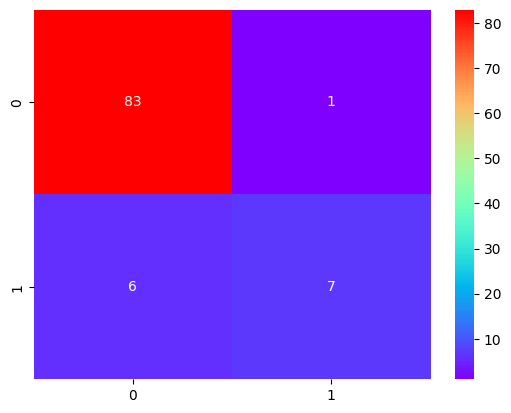

In [ ]:
y_pred_LR_tfidf_a = LR_model_tfidf_a.predict(test_x_tfidf_a)
cm_LR_tfidf_a = confusion_matrix(np.array(y_test_a),y_pred_LR_tfidf_a)
sns.heatmap(cm_LR_tfidf_a, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) TF-IDF Score Vectorizer  Augmented with data original test data")
print(classification_report(y_test_a,y_pred_LR_tfidf_a))

In [ ]:
LR_tfidf_a=classification_report(y_test_a,y_pred_LR_tfidf_a,output_dict=True)
LR_tfidf_a=pd.DataFrame(LR_tfidf_a)
LR_tfidf_a= LR_tfidf_a.transpose()
LR_tfidf_a

,precision,recall,f1-score,support
0,0.932584,0.988095,0.959538,84.000000
1,0.875000,0.538462,0.666667,13.000000
accuracy,0.927835,0.927835,0.927835,0.927835
macro avg,0.903792,0.763278,0.813102,97.000000
weighted avg,0.924867,0.927835,0.920287,97.000000


###### **Test data from same 2nd Data base**

Confusion matrix for Logistic Regression (RL) Tfidf Vectorizer Augmented with  2nd test data
              precision    recall  f1-score   support

           0       0.44      0.95      0.61        88
           1       0.97      0.52      0.68       220

    accuracy                           0.65       308
   macro avg       0.71      0.74      0.64       308
weighted avg       0.82      0.65      0.66       308



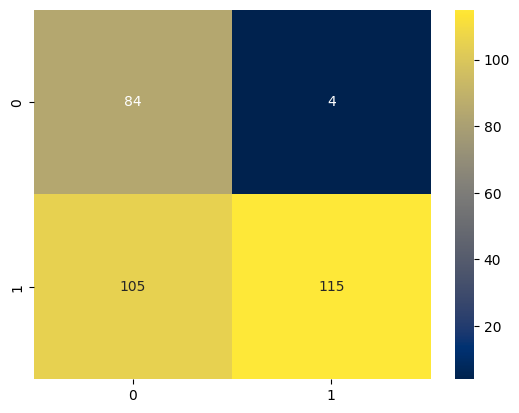

In [ ]:
y_pred_LR_tfidf2_a = LR_model_tfidf_a.predict(test2_x_tfidf_a)
cm_LR_tfidf2_a = confusion_matrix(np.array(y_test2_a),y_pred_LR_tfidf2_a)
sns.heatmap(cm_LR_tfidf2_a, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) Tfidf Vectorizer Augmented with  2nd test data")
print(classification_report(y_test2_a,y_pred_LR_tfidf2_a))

In [ ]:
LR_tfidf2_a=classification_report(y_test2,y_pred_LR_tfidf2_a,output_dict=True)
LR_tfidf2_a=pd.DataFrame(LR_tfidf2_a)
LR_tfidf2_a= LR_tfidf2_a.transpose()
LR_tfidf2_a

,precision,recall,f1-score,support
0,0.444444,0.954545,0.606498,88.000000
1,0.966387,0.522727,0.678466,220.000000
accuracy,0.646104,0.646104,0.646104,0.646104
macro avg,0.705415,0.738636,0.642482,308.000000
weighted avg,0.817260,0.646104,0.657904,308.000000


#### **Embedded FastText vectors pre-trained by Facebook**

##### **Original Data**

In [ ]:
best_params_Emb = logistic_regression_grid_search(trainEmb,y_train)

In [ ]:
print(best_params_Emb)

{'C': 0.005, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': None, 'solver': 'sag'}


In [ ]:
LR_model_Emb=LogisticRegression(**best_params_Emb)

In [ ]:
LR_model_Emb.fit(trainEmb,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.005, max_iter=200, n_jobs=-1, penalty=None, solver='sag')

In [ ]:
print('\nResults using "fastText" embedded vectors')
print('Results Logistic Regression:')
print('LR_emb: Train-accuracy: %.2f%%' % (100*LR_model_Emb.score(trainEmb, y_train)))
print('LR_emb: Val-accuracy: %2.f%%' % (100*LR_model_Emb.score(valEmb, y_val)))
LR_emb_train=100*LR_model_Emb.score(trainEmb, y_train)
LR_emb_val=100*LR_model_Emb.score(valEmb, y_val)


Results using "fastText" embedded vectors
Results Logistic Regression:
LR_emb: Train-accuracy: 98.83%
LR_emb: Val-accuracy: 93%


##### **Model Evaluation**

######**Test data from same Data base**

Confusion matrix for Logistic Regression (RL) Embeddings with original test data
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        84
           1       0.73      0.62      0.67        13

    accuracy                           0.92        97
   macro avg       0.83      0.79      0.81        97
weighted avg       0.91      0.92      0.91        97



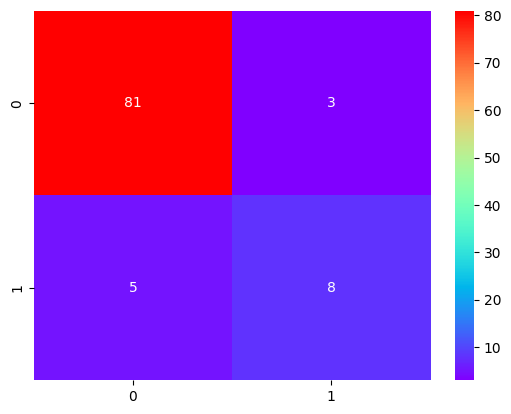

In [ ]:
y_pred_LR_Emb = LR_model_Emb.predict(testEmb)
cm_LR_Emb = confusion_matrix(np.array(y_test),y_pred_LR_Emb)
sns.heatmap(cm_LR_Emb, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) Embeddings with original test data")
print(classification_report(y_test,y_pred_LR_Emb))

In [ ]:
LR_Emb=classification_report(y_test,y_pred_LR_Emb,output_dict=True)
LR_Emb=pd.DataFrame(LR_Emb)
LR_Emb= LR_Emb.transpose()
LR_Emb

,precision,recall,f1-score,support
0,0.941860,0.964286,0.952941,84.000000
1,0.727273,0.615385,0.666667,13.000000
accuracy,0.917526,0.917526,0.917526,0.917526
macro avg,0.834567,0.789835,0.809804,97.000000
weighted avg,0.913101,0.917526,0.914574,97.000000


###### **Test data from same 2nd Data base**

Confusion matrix for Logistic Regression (RL) Embeddings with 2nd test data
              precision    recall  f1-score   support

           0       0.50      0.92      0.65        88
           1       0.95      0.64      0.76       220

    accuracy                           0.72       308
   macro avg       0.73      0.78      0.71       308
weighted avg       0.82      0.72      0.73       308



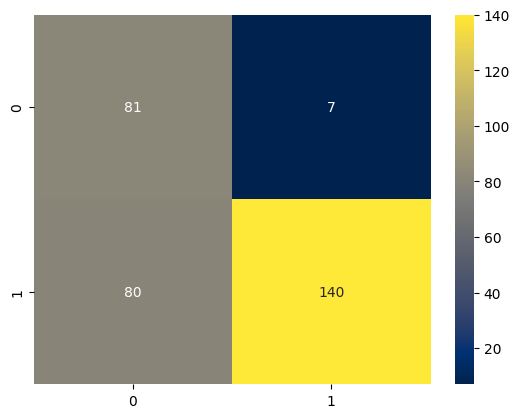

In [ ]:
y_pred_LR_Emb2 = LR_model_Emb.predict(test2Emb)
cm_LR_Emb2 = confusion_matrix(np.array(y_test2),y_pred_LR_Emb2)
sns.heatmap(cm_LR_Emb2, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) Embeddings with 2nd test data")
print(classification_report(y_test2,y_pred_LR_Emb2))


In [ ]:
LR_Emb2=classification_report(y_test2,y_pred_LR_Emb2,output_dict=True)
LR_Emb2=pd.DataFrame(LR_Emb2)
LR_Emb2= LR_Emb2.transpose()
LR_Emb2

,precision,recall,f1-score,support
0,0.503106,0.920455,0.650602,88.000000
1,0.952381,0.636364,0.762943,220.000000
accuracy,0.717532,0.717532,0.717532,0.717532
macro avg,0.727743,0.778409,0.706773,308.000000
weighted avg,0.824017,0.717532,0.730846,308.000000


##### **Augmented Data**

In [ ]:
best_params_Emb_a = logistic_regression_grid_search(trainEmb_a,y_train_a)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_ite

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1

[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=bal

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1

[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.5s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=bala

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1

[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.5, class_weight=bal

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=lbfgs; total time=   1.1s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=liblinear; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1

[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   2.3s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=l

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_ite

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.1s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=None, max_ite

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=l

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.5s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=bal

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=sag; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=100, n_jobs=-1, penalty=None, solver=saga; total time=   0.6s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=bala

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=200, n_jobs=-1, penalty=None, solver=saga; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   1.0s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=1.0, class_weight

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=sag; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
600 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.sol

[CV] END C=1.0, class_weight=balanced, max_iter=300, n_jobs=-1, penalty=None, solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(best_params_Emb_a)

{'C': 0.5, 'class_weight': None, 'max_iter': 100, 'n_jobs': -1, 'penalty': None, 'solver': 'saga'}


In [ ]:
LR_model_Emb_a=LogisticRegression(**best_params_Emb_a)

In [ ]:
LR_model_Emb_a.fit(trainEmb_a,y_train_a)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.5, n_jobs=-1, penalty=None, solver='saga')

In [ ]:
print('\nResults using "fastText" embedded vectors with Augmented Data')
print('Results Logistic Regression:')
print('LR_emb_a: Train-accuracy: %.2f%%' % (100*LR_model_Emb_a.score(trainEmb_a, y_train_a)))
print('LR_emb_a: Val-accuracy: %2.f%%' % (100*LR_model_Emb_a.score(valEmb_a, y_val_a)))
LR_emb_train_a=100*LR_model_Emb_a.score(trainEmb_a, y_train_a)
LR_emb_val_a=100*LR_model_Emb_a.score(valEmb_a, y_val_a)


Results using "fastText" embedded vectors with Augmented Data
Results Logistic Regression:
LR_emb_a: Train-accuracy: 94.37%
LR_emb_a: Val-accuracy: 92%


##### **Model Evaluation- Augmented**

###### **Test data from same Data base**

Confusion matrix for Logistic Regression (RL) embeddings Augmented with data original test data
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        84
           1       0.62      0.62      0.62        13

    accuracy                           0.90        97
   macro avg       0.78      0.78      0.78        97
weighted avg       0.90      0.90      0.90        97



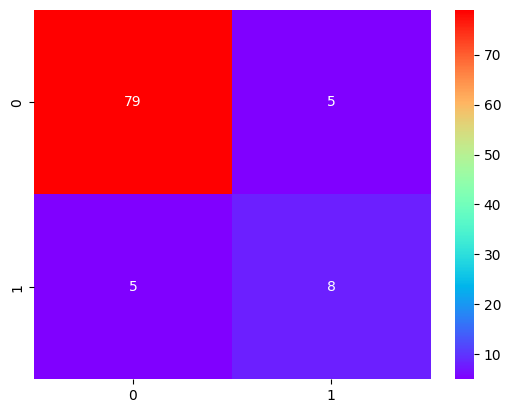

In [ ]:
y_pred_LR_Emb_a = LR_model_Emb_a.predict(testEmb_a)
cm_LR_Emb_a = confusion_matrix(np.array(y_test_a),y_pred_LR_Emb_a)
sns.heatmap(cm_LR_Emb_a, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) embeddings Augmented with data original test data")
print(classification_report(y_test_a,y_pred_LR_Emb_a))

In [ ]:
LR_Emb_a=classification_report(y_test_a,y_pred_LR_Emb_a,output_dict=True)
LR_Emb_a=pd.DataFrame(LR_Emb_a)
LR_Emb_a= LR_Emb_a.transpose()
LR_Emb_a

,precision,recall,f1-score,support
0,0.940476,0.940476,0.940476,84.000000
1,0.615385,0.615385,0.615385,13.000000
accuracy,0.896907,0.896907,0.896907,0.896907
macro avg,0.777930,0.777930,0.777930,97.000000
weighted avg,0.896907,0.896907,0.896907,97.000000


###### **Test data from same 2nd Data base**

Confusion matrix for Logistic Regression (RL) Embeddings Augmented with  2nd test data
              precision    recall  f1-score   support

           0       0.51      0.91      0.65        88
           1       0.95      0.65      0.77       220

    accuracy                           0.72       308
   macro avg       0.73      0.78      0.71       308
weighted avg       0.82      0.72      0.73       308



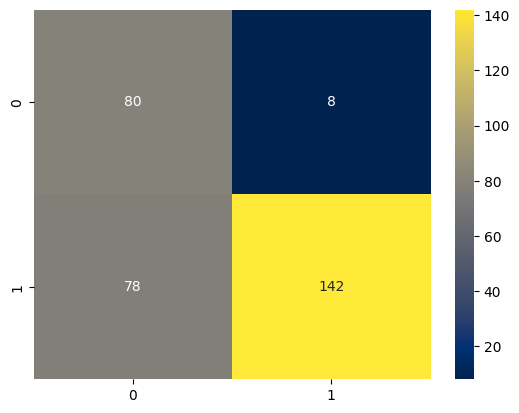

In [ ]:
y_pred_LR_Emb2_a = LR_model_Emb_a.predict(test2Emb_a)
cm_LR_Emb2_a = confusion_matrix(np.array(y_test2_a),y_pred_LR_Emb2_a)
sns.heatmap(cm_LR_Emb2_a, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) Embeddings Augmented with  2nd test data")
print(classification_report(y_test2_a,y_pred_LR_Emb2_a))

In [ ]:
LR_Emb2_a=classification_report(y_test2,y_pred_LR_Emb2_a,output_dict=True)
LR_Emb2_a=pd.DataFrame(LR_Emb2_a)
LR_Emb2_a= LR_Emb2_a.transpose()
LR_Emb2_a

,precision,recall,f1-score,support
0,0.506329,0.909091,0.650407,88.000000
1,0.946667,0.645455,0.767568,220.000000
accuracy,0.720779,0.720779,0.720779,0.720779
macro avg,0.726498,0.777273,0.708987,308.000000
weighted avg,0.820856,0.720779,0.734093,308.000000


## **Final reports**

In [ ]:
## all the train results
train_results = {
    'Train-accuracy': [LR_count_train, LR_count_train_a,
                       LR_tfidf_train,LR_tfidf_train_a,
                       LR_emb_train,LR_emb_train_a],
    'Val-accuracy': [LR_count_val, LR_count_val_a,
                     LR_tfidf_val,LR_tfidf_val_a,
                     LR_emb_val,LR_emb_val_a],
    'Difference' : [(LR_count_train-LR_count_val), (LR_count_train-LR_count_val_a),
                    (LR_tfidf_train-LR_tfidf_val),(LR_tfidf_train_a-LR_tfidf_val_a),
                    (LR_emb_train-LR_emb_val),(LR_emb_train_a-LR_emb_val_a)]
}


train_results = pd.DataFrame(train_results, index=['LR_count', 'LR_count_a', 'LR_tfidf','LR_tfidf_a','LR_emb','LR_emb_a']).T
train_results.to_excel('train_resultsLR.xlsx')
files.download('train_resultsLR.xlsx')


train_results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,LR_count,LR_count_a,LR_tfidf,LR_tfidf_a,LR_emb,LR_emb_a
Train-accuracy,98.832685,97.983193,96.887160,96.134454,98.832685,94.369748
Val-accuracy,93.750000,92.708333,94.791667,93.750000,92.708333,91.666667
Difference,5.082685,6.124351,2.095493,2.384454,6.124351,2.703081


In [ ]:
# all the confusion matrix results
result = pd.concat([LR_count,LR_count2,LR_count_a,LR_count2_a,LR_tfidf,LR_tfidf2,LR_tfidf_a,LR_tfidf2_a,
                    LR_Emb,LR_Emb2,LR_Emb_a,LR_Emb2_a],
                   axis=1,
                   keys=['LR_count','LR_count_test2','LR_count_a','LR_count_a_test2','LR_tfidf','LR_tfidf_test2','LR_tfidf_a','LR_tfidf_a_test2',
                    'LR_Emb','LR_Emb_test2','LR_Emb_a','LR_Emb_a_test2'])
result.to_excel('resultsLR.xlsx')
files.download('resultsLR.xlsx')
result

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LR_count                                LR_count_test2  \
             precision    recall  f1-score    support      precision   
0             0.941860  0.964286  0.952941  84.000000       0.653543   
1             0.727273  0.615385  0.666667  13.000000       0.972376   
accuracy      0.917526  0.917526  0.917526   0.917526       0.840909   
macro avg     0.834567  0.789835  0.809804  97.000000       0.812959   
weighted avg  0.913101  0.917526  0.914574  97.000000       0.881281   

                                             LR_count_a            ...  \
                recall  f1-score     support  precision    recall  ...   
0             0.943182  0.772093   88.000000   0.921348  0.976190  ...   
1             0.800000  0.877805  220.000000   0.750000  0.461538  ...   
accuracy      0.840909  0.840909    0.840909   0.907216  0.907216  ...   
macro avg     0.871591  0.824949  308.000000   0.835674  0.718864  ...   
weighted avg  0.840909  0.847602  308.000000   0.898384  0.907216  ...   

             LR_Emb_test2              LR_Emb_a                      \
                 f1-score     support precision    recall  f1-score   
0                0.650602   88.000000  0.940476  0.940476  0.940476   
1                0.762943  220.000000  0.615385  0.615385  0.615385   
accuracy         0.717532    0.717532  0.896907  0.896907  0.896907   
macro avg        0.706773  308.000000  0.777930  0.777930  0.777930   
weighted avg     0.730846  308.000000  0.896907  0.896907  0.896907   

                        LR_Emb_a_test2                                  
                support      precision    recall  f1-score     support  
0             84.000000       0.506329  0.909091  0.650407   88.000000  
1             13.000000       0.946667  0.645455  0.767568  220.000000  
accuracy       0.896907       0.720779  0.720779  0.720779    0.720779  
macro avg     97.000000       0.726498  0.777273  0.708987  308.000000  
weighted avg  97.000000       0.820856  0.720779  0.734093  308.000000  

[5 rows x 48 columns]

In [ ]:
f1_scores = result.xs('f1-score', axis=1, level=1)
f1_scores = f1_scores.rename_axis("f1-scores", axis="columns")
f1_scores.to_excel('f1scoresLR.xlsx')
files.download('f1scoresLR.xlsx')
f1_scores

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

f1-scores,LR_count,LR_count_test2,LR_count_a,LR_count_a_test2,LR_tfidf,LR_tfidf_test2,LR_tfidf_a,LR_tfidf_a_test2,LR_Emb,LR_Emb_test2,LR_Emb_a,LR_Emb_a_test2
0,0.952941,0.772093,0.947977,0.680672,0.952941,0.748718,0.959538,0.606498,0.952941,0.650602,0.940476,0.650407
1,0.666667,0.877805,0.571429,0.798942,0.666667,0.883610,0.666667,0.678466,0.666667,0.762943,0.615385,0.767568
accuracy,0.917526,0.840909,0.907216,0.753247,0.917526,0.840909,0.927835,0.646104,0.917526,0.717532,0.896907,0.720779
macro avg,0.809804,0.824949,0.759703,0.739807,0.809804,0.816164,0.813102,0.642482,0.809804,0.706773,0.777930,0.708987
weighted avg,0.914574,0.847602,0.897512,0.765151,0.914574,0.845070,0.920287,0.657904,0.914574,0.730846,0.896907,0.734093


In [ ]:
recalls = result.xs('recall', axis=1, level=1)
recalls = recalls.rename_axis("recall", axis="columns")
recalls.to_excel('recallsLR.xlsx')
files.download('recallsLR.xlsx')
recalls

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

recall,LR_count,LR_count_test2,LR_count_a,LR_count_a_test2,LR_tfidf,LR_tfidf_test2,LR_tfidf_a,LR_tfidf_a_test2,LR_Emb,LR_Emb_test2,LR_Emb_a,LR_Emb_a_test2
0,0.964286,0.943182,0.976190,0.920455,0.964286,0.829545,0.988095,0.954545,0.964286,0.920455,0.940476,0.909091
1,0.615385,0.800000,0.461538,0.686364,0.615385,0.845455,0.538462,0.522727,0.615385,0.636364,0.615385,0.645455
accuracy,0.917526,0.840909,0.907216,0.753247,0.917526,0.840909,0.927835,0.646104,0.917526,0.717532,0.896907,0.720779
macro avg,0.789835,0.871591,0.718864,0.803409,0.789835,0.837500,0.763278,0.738636,0.789835,0.778409,0.777930,0.777273
weighted avg,0.917526,0.840909,0.907216,0.753247,0.917526,0.840909,0.927835,0.646104,0.917526,0.717532,0.896907,0.720779


# **Conclusions:**


After evaluating the logistic regression model with different the following variants:

- LR_count -> Logistic Regression with count matrices.
- LR_count_a -> Logistic regression with count matrices and training data augmentation.
- LR_tfidf->Logistic Regression with tfidf matrices.
- LR_tfidf_a->Logistic regression with tfidf matrices and training data augmentation.
- LR_Emb -> Logistic Regression with embedded fastText vectors.
- LR_Emb_a -> Logistic Regression with embedded fastText vectors and training data augmentation.


We obtained the following training results.




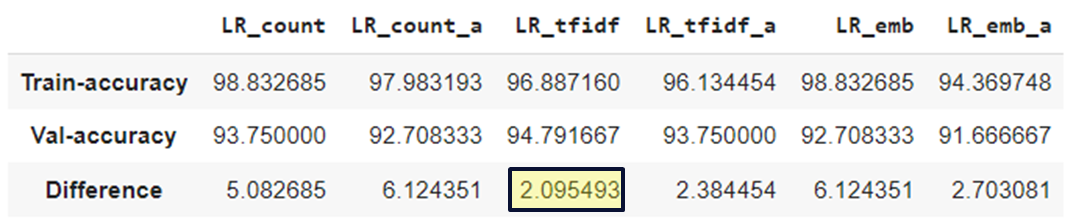

Where we can see that the best model is **LR_tfidf**. The answer to the question why it is the best model is because it shows a difference in accuracy between training and validation of **2.095%**. Which shows us that this Logistic regression configuration with tfidf matrices does not show overtraining as in the other configurations.

Another point to evaluate is when using the data partition test data set and using a data set extracted from another website called https://www.edmunds.com/. For this, we proceeded to evaluate with the F1-score metric for the following reasons.

- Good for imbalanced classes: When the classes in the test data are imbalanced (that is, there are many more instances of one class than another), accuracy alone can be misleading. For example, a model that always predicts the majority class could have high precision but very low recall. The F1-score takes into account both precision and recall, making it more suitable for evaluating models in cases of imbalanced classes.

- Shows a balance between precision and recall: The F1-score is a metric that combines the model's precision and recall into a single measure. This is useful because there is often a trade-off between precision and recall: increasing precision can reduce recall and vice versa. The F1-score provides a way to evaluate the balance between these two aspects of model performance.

The following results show the f-1 score values for each model configuration showing the test with the data from the same website (test) and with the data from another website (test2)



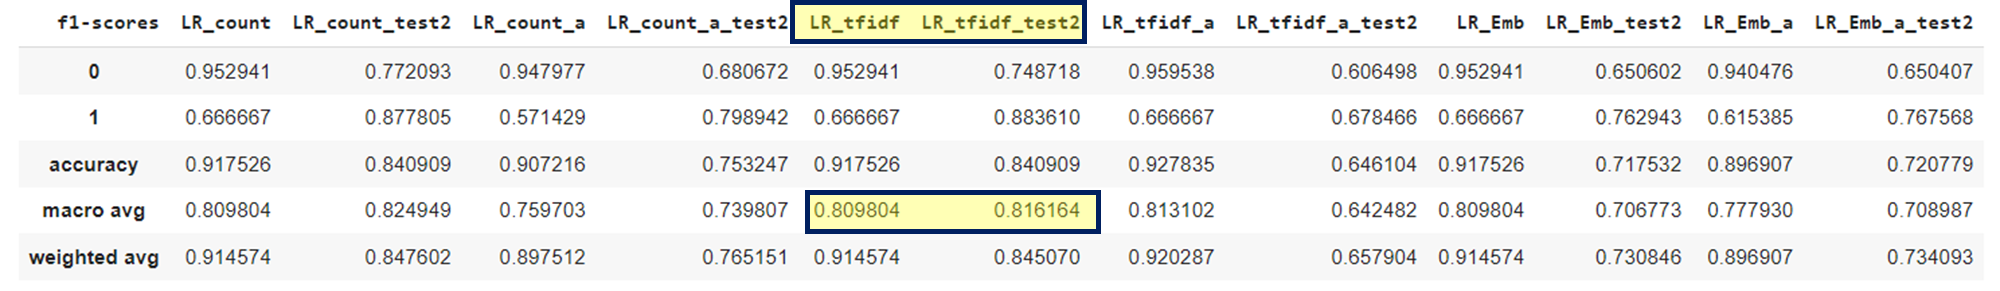

The results show **LR_tfidf** as the one that offers a better balance between the classes if we consider macro avg that averages the value of f1-score for class 0 and class 1. And it shows less difference comparing the test data from the same website(test) compared to the website(test2).

To conclude, of all the configurations of the logistic regression model, the LR_tfidf model showed the best result, since as observed in some, the model is overtrained and this is observed when viewing the f1-score values with the test data for both cases.

Something that is observed is that in all cases the data Augmentation (the comments generated with GPT2) did not provide a benefit to improve the models and when evaluating them with data that were not seen during training, in some cases their f1-score values were reduced.

# **Best model label prediction with Test2 data**

In [ ]:
final_preds = [{ 'text': X_test2[i], 'pred': pred , 'Original_label': Y_test2[i]}for i,pred in enumerate(y_pred_LR_tfidf2)]

In [ ]:
df_pred = pd.DataFrame(final_preds)
df_pred.to_excel('predictions_LR_tfidf.xlsx')
files.download('predictions_LR_tfidf.xlsx')
df_pred

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,text,pred,Original_label
0,"I special ordered my car , waited patiently fo...",0,0
1,Auto stop engine can not be permanently disabl...,1,0
2,I leased a high altitude in August 2034. I did...,0,0
3,Car is awesome! Couldnt be more happy with my...,0,1
4,Bought a brand new Rubicon for my son. Fully L...,0,0
...,...,...,...
303,Super happy with my purchase,1,1
304,Just the right size. the only complaint is the...,1,1
305,This subcompact SUV is roomy enough for my fam...,1,1
306,Gorgeous vehicle loaded with details comparabl...,1,1


# **References:**

- Hugging Face. (s.f.). Text generation strategies. En Hugging Face Transformers Documentation. Recuperado de https://huggingface.co/docs/transformers/en/generation_strategies#diverse-beam-search-decoding

- Liu, X. (s.f.). distilbert-base-multilingual-cased-sentiments-student. Hugging Face. Recuperado de https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

- Hugging Face. (s.f.). Transformers: Training & Fine-Tuning. Recuperado de https://huggingface.co/docs/transformers/training

- ParseHub. (n.d.). What Is Web Scraping? | ParseHub. ParseHub. Retrieved January 28, 2024, from https://www.parsehub.com/blog/what-is-web-scraping/

- Falcón Morales, L. E. (2023). Maestría en Inteligencia Artificial Aplicada. ITESM

- Kumar Mukhiya, S., y Ahmed, U. (2020). Hands-On Exploratory Data Analysis with Python. Packt Publishing.

- Falcón Morales, L. E. (2023). Expresiones regulares (regex). Maestría en Inteligencia Artificial Aplicada. ITESM.

- KeepCoding. (2023). ¿Qué es el count vectorizer?. https://keepcoding.io/blog/que-es-el-count-vectorizer/#:~:text=El%20count%20vectorizer%20es%20una,de%20a%20nivel%20de%20token.

- KeepCoding. (2023). ¿Qué es el TF-IDF Vectorizer?. https://keepcoding.io/blog/que-es-el-algoritmo-tf-idf-vectorizer/#:~:text=El%20TF%2DIDF%20tiene%20en,de%20TF%2DIDF%20Vectorizer%20bajo.

- Facebook. (2022). Get started. https://fasttext.cc/docs/en/support.html

- Introduction to word embeddings – word2vec, glove, FastText and Elmo. Data Science Machine Learning Deep Learning. (n.d.). https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/

- scikit-learn. (n.d.). LogisticRegression — scikit-learn 0.24.2 documentation.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

- scikit-learn. (n.d.). GridSearchCV — scikit-learn 0.24.2 documentation.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html